<a href="https://colab.research.google.com/github/Atharva-D/Breast-Cancer-Detection/blob/main/SDP_Mobilenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import *
from tkinter import *
from PIL import ImageTk, Image
import PIL.Image
from matplotlib.patches import Circle
import os
import sys
# path manipulation
from pathlib import Path
# regex
import re
# plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Circle
# data manipulation / preparation
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# image manipulation

from PIL import Image
from IPython.display import Image
# metrics
from sklearn.metrics import confusion_matrix, classification_report
# keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


In [3]:
class MammoScan:
    def __init__(self, scan, sc_info):
        self.__scan = scan
        self.__sc_info = sc_info
    
    @property # scan image
    def scan(self):
        return self.__scan
    
    @property # scan info
    def scan_info(self):
        return self.__sc_info
    
    @property # from the scan file name
    def scan_name(self):
        return self.__sc_info.name
    
    @property # x coordinate of the abnormality
    def x(self):
        return self.__sc_info.x
    
    @property # y coordinate of the abnormality
    def y(self):
        return self.__sc_info.y
    
    @property # radius of the abnormality
    def radius(self):
        return self.__sc_info.radius

    @property # class of the abnormality
    def ab_class(self):
        return self.__sc_info.ab_class
    
    @property # background tissue of the abnormality
    def bg(self):
        return self.__sc_info.bg
    
    @property # severity of the abnormality
    def severity(self):
        return self.__sc_info.severity

    @property 
    # generates cropped downsized rotated images of the abnormality
    def transformations(self):
        return self.__transform()
    
    @property
    # returns the matricial representation fo the scan image
    def pixel_matrix(self):
        return np.array(self.scan)
    
    # instance method
    def plot(self):

        # Create a figure. Equal aspect so circles look circular
        fig, ax = plt.subplots(1)

        fig.set_size_inches(8, 6)
        ax.set_aspect('equal')

        # Show the image
        ax.imshow(self.scan, cmap=plt.cm.gray_r)
        ax.set_ylim(bottom=0, top=1024)
        ax.set_title(self.scan_name)
        

        # create a circle to patch on the image
        x, y, r = self.__get_crop_coords()
        print(f'{x}, {y}, {r}')
        circ = Circle((x,y), r, fill=False)
        ax.add_patch(circ)
    
    # private method
    def __set_x(self, xValue):
        self.__sc_info.x = xValue
    
    # private method
    def __set_y(self, yValue):
        self.__sc_info.y = yValue
    
    # private method
    def __set_radius(self, rValue):
        self.__sc_info.radius = rValue
        
    # private method
    def __get_crop_coords(self):
        '''Returns a tuple with x, y and r'''
        # check scan class to decide on how to crop
        if pd.isnull(self.radius):
            radius = 48.0
            self.__set_radius(radius)
        if pd.isnull(self.x):
            x = float(np.random.randint(500, 513))
            self.__set_x(x)
        if pd.isnull(self.y):
            y = float(np.random.randint(500, 513))
            self.__set_y(y)
            
        return (self.x, 1024.0-self.y, self.radius)
    
    # private method
    def __transform(self):
        '''Creates a dict 
                  with rotated and mirrored versions of self.scan'''
        # create dictionary
        transformations = dict()
        # get crop values
        x, y, r = self.__get_crop_coords()
        # crop and resize scan
        cropped_scan = self.scan.crop((x-r, y-r, x+r, y+r))
        resized_scan = cropped_scan.resize((256,256))
        # create rotated images
        for angle in (0, 90, 180, 270):
            rotated = resized_scan.rotate(angle) # rotated by angle
            mirr_tp = rotated.transpose(PIL.Image.FLIP_TOP_BOTTOM)
            mirr_lr = rotated.transpose(PIL.Image.FLIP_LEFT_RIGHT)
            
            transformations[angle] = dict(zip(['rotated', 'mirr_lr', 'mirr_tp'], 
                                              [rotated, mirr_lr, mirr_tp]))

        return transformations

In [4]:
def clean_ds_files(df: pd.DataFrame) -> pd.DataFrame:
    '''Removes records with invalid data
         and cast x and y to float'''
    new_df = df.copy()
    # search for invalid x values for removal
    indices = new_df.x[lambda x: x == '*NOTE'].index
    
    for idx in indices:
        n_idx = new_df.index.get_loc(idx)
        # drop from dataset
        new_df.drop(new_df.index[n_idx], inplace=True)
        # delete from directory
        delete_image(idx)

    # make x and y float values
    new_df.x = new_df.x.astype(float)
    new_df.y = new_df.y.astype(float)
    
    return new_df


def delete_image(filename: str, directory='/content/gdrive/MyDrive/SDP/all-mias/'):
    '''Deletes original image files that won't be initially used'''
    paths = Path(directory).glob('**/*.pgm')
    filename += '.pgm'
    for f_path in sorted(paths):
        try:
            if f_path.name == filename:
                os.remove(f_path)
                break
        except FileNotFoundError as fnf:
            print('{fnf}') 
            
            
def create_scan_filenames_dic(path: str) -> dict:
    '''Creates a dictionary with image filenames'''
    paths = Path(path).glob('**/*.pgm')
    img_dic = dict()
    for f_path in sorted(paths):
        # get full filename
        full_fname = f_path.name
        # get filename (no extension)
        filename = f_path.stem
        # create dictionary
        img_dic[filename] = f_path.as_posix()
    
    return img_dic
        

def save_subsamples(scans_dic: dict(), df: pd.DataFrame) -> pd.DataFrame:
    '''Save subsamples to the subsamples folder'''
    # define subsamples folder
    folder = '../subsamples'
    df_sub = pd.DataFrame()
    try:
        # create if not yet
        if not os.path.exists(folder):
            os.mkdir(folder)
    except:
        print('An error occurred when searching for the folder')
        
    # iterate dictionary of filenames
    for scan_name, filename in scans_dic.items():
        
        # create image and scan info objects
        try:
            scan = PIL.Image.open(filename)
        except FileNotFoundError as fnf:
            print({fnf})
            
        scan_info = df.loc[scan_name].copy()
        # create the MammoScan object
        m_scan = MammoScan(scan, scan_info)
        # get the transformations
        transf_scans = m_scan.transformations
        # create filenames
        filenames = create_subsample_filename(scan_name, transf_scans)
        # get transformed scans Image objects
        imgs = get_transformed_scans(transf_scans)
        # prepare for saving
        fs_and_is = list(zip(filenames, imgs))
        
        for filename, image in fs_and_is:
            # create new observation with subsample name
            # name the series to become an index in the new dataframe
            scan_info.name = re.match(r'(.*)\.[^.]+$', filename).group(1)
            # create pixel matrix
            pixel_matrix = np.asarray(image)
            
            scan_info['p_matrix'] = pixel_matrix
            
            scan_info['subsample_path'] = os.path.join('../subsamples', filename)

            # append to dataframe
            df_sub = df_sub.append(scan_info.loc[['ab_class', 'bg', 
                                                  'severity', 'subsample_path',
                                                  'p_matrix']])
            
            #print(scan_name)././
            path = os.path.join('../subsamples', filename) 
            #print(path)
            try:
                image.save(path, compress_level=0)
            except ValueError as ve:
                print('Output format could not be determined from the file name.')
            except OSError as ose:
                print('File could not be written.')
                print({ose})
        
    return df_sub

def create_subsample_filename(scan_name: str, transf_dic: dict) -> list:
    '''Creates suffix pattern filename for transformed scans'''
    filename = ''
    file_names = list()
    for angle, transfs in transf_dic.items():
        for tf in transfs.keys():
            filename += f'{scan_name}_{angle}_{tf}.png'
            #print(filename)
            file_names.append(filename)
            filename = ''
            
    return file_names


def get_transformed_scans(transf_dic: dict) -> list:
    scans = list()
    for angle, transfs in transf_dic.items():
        for scan in transfs.values():
            scans.append(scan)
    
    return scans


def generate_subsamples(path_to_originals: str, mias_df: pd.DataFrame) -> pd.DataFrame:
    ''' Generates the subsamples for training and testing.
        Files are saved in ../subsamples
        it returns a dataframe with the path to each subsample '''
    scans_filenames_dic = create_scan_filenames_dic(path_to_originals)
    final = save_subsamples(scans_filenames_dic, mias_df)
    return final


def balance_by_severity(df: pd.DataFrame, ab_class: str) -> pd.DataFrame:
    ''' Balances an abnormality class based on severity '''
    # deep copy
    df = df.copy()
    # if class == NORM, reduce norm to the avg class sample amount
    if ab_class == 'NORM':
        avg = int(df[df.ab_class != 'NORM'].groupby(['ab_class']).severity.size().mean())
        return df[(df.ab_class == ab_class)].sample(avg)   
    
    sev_counts = df[df.ab_class== ab_class].severity.value_counts()
    n_benign = sev_counts.loc['B']
    n_malign = sev_counts.loc['M']
    
    if n_benign > n_malign:
        # downsize 'B'
        benign = df[(df.ab_class == ab_class) & (df.severity == 'B')].sample(n_malign, replace=False)
        malign = df[(df.ab_class == ab_class) & (df.severity == 'M')]
    else:
        benign = df[(df.ab_class == ab_class) & (df.severity == 'B')]
        malign = df[(df.ab_class == ab_class) & (df.severity == 'M')].sample(n_benign, replace=False)
        
    return pd.concat([benign, malign])


def create_mias_dataset(file_path: str) -> pd.DataFrame:
    ''' Creates a dataset with the data about the scans '''
    # create a dataset
    mammo = pd.read_table(file_path, delimiter='\s', engine='python')
    # rename the class column to avoid conflicts with the class keyword in python
    mammo.columns = ['refnum', 'bg', 'ab_class', 'severity', 'x', 'y', 'radius']
    # fill null severity with A for NORM class
    mammo.severity = mammo.severity.fillna('A')
    # drop duplicates
    mammo.drop_duplicates(subset='refnum', keep='first', inplace=True)
    # set refnum as index
    mammo.set_index(keys='refnum', drop=True, inplace=True)
    # return clean df and delete unuseful images
    return clean_ds_files(mammo)

def plot_results(acc,val_acc,loss, val_loss):
    # create grit
    fig, (ax1, ax2) = plt.subplots(nrows = 1,
                                   ncols = 2,
                                   figsize = (15,6),
                                   sharex =True)
    
    # set plots
    plot1 = ax1.plot(range(0, len(acc)),
                     acc,
                     label = 'accuracy')
    
    
    plot2 = ax1.plot(range(0, len(val_acc)),
                     val_acc,
                     label = 'val_accuracy')

    ax1.set(title = 'Accuracy And Val Accuracy progress',
            xlabel = 'epoch',
            ylabel = 'accuracy/ validation accuracy')

    ax1.legend()

    plot3 = ax2.plot(range(0, len(loss)),
                     loss,
                     label = 'loss')
    
    plot4 = ax2.plot(range(0, len(val_loss)),
                     val_loss,
                     label = 'val_loss')
    
    ax2.set(title = 'Loss And Val loss progress',
            xlabel = 'epoch',
            ylabel = 'loss/ validation loss')

    ax2.legend()

    fig.suptitle('Result Of Model', fontsize = 20, fontweight = 'bold')
    fig.savefig('Accuracy_Loss_figure.png')
    plt.tight_layout()
    plt.show()
    
    
def balance_df_by_severity(df: pd.DataFrame) -> pd.DataFrame:
    final_df = pd.DataFrame()
    for ab_class in df.ab_class.unique():
        class_df = balance_by_severity(df, ab_class)
        final_df = pd.concat([class_df, final_df])
        
    return final_df.sample(len(final_df), replace = False)


def full_balance_df_by_severity(df: pd.DataFrame) -> pd.DataFrame:
    final_df = pd.DataFrame()
    for ab_class in df.ab_class.unique():
        if ab_class == 'NORM':
            class_df = balance_by_severity(df, ab_class).sample(96, replace = False)
        else:
            class_df = balance_by_severity(df, ab_class)
            class_df_B = class_df[class_df.severity == 'B'].sample(48, replace = False)
            class_df_A = class_df[class_df.severity == 'M'].sample(48, replace = False)
            class_df = pd.concat([class_df_A, class_df_B])
            class_df = class_df.sample(len(class_df), replace = False)
        final_df = pd.concat([class_df, final_df])
        
    return final_df.sample(len(final_df), replace = False)

def display_probabilities(prediction):
    for index, probability in enumerate(prediction):
        print(f'{index}: {probability:.10%}')
        
def create_final_results_df() -> pd.DataFrame:
    # create dataframe for results
    data = {"calcifications": [0, 0, 0, 0]}
    return pd.DataFrame.from_dict(data, orient='index', columns=['test_accuracy', 'precision','recall', 'f1-score'])

In [5]:
mammo_df = create_mias_dataset("/content/gdrive/My Drive/SDP/all-mias/MIAS_Cancer_info.txt")
mammo_df.head()

,bg,ab_class,severity,x,y,radius
refnum,,,,,,
mdb001,G,CIRC,B,535.0,425.0,197.0
mdb002,G,CIRC,B,522.0,280.0,69.0
mdb003,D,NORM,A,NaN,NaN,NaN
mdb004,D,NORM,A,NaN,NaN,NaN
mdb005,F,CIRC,B,477.0,133.0,30.0


In [6]:
len(mammo_df)

322

In [7]:
mammo = generate_subsamples("/content/gdrive/MyDrive/SDP/all-mias",mammo_df)
mammo.head()

,ab_class,bg,p_matrix,severity,subsample_path
mdb001_0_rotated,CIRC,G,"[[0, 0, 0, 0, 1, 1, 3, 4, 4, 4, 5, 5, 5, 6, 5,...",B,../subsamples/mdb001_0_rotated.png
mdb001_0_mirr_lr,CIRC,G,"[[125, 128, 113, 102, 98, 94, 91, 94, 97, 99, ...",B,../subsamples/mdb001_0_mirr_lr.png
mdb001_0_mirr_tp,CIRC,G,"[[0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,...",B,../subsamples/mdb001_0_mirr_tp.png
mdb001_90_rotated,CIRC,G,"[[125, 125, 132, 121, 110, 99, 91, 87, 87, 88,...",B,../subsamples/mdb001_90_rotated.png
mdb001_90_mirr_lr,CIRC,G,"[[59, 59, 61, 64, 65, 64, 67, 70, 73, 75, 77, ...",B,../subsamples/mdb001_90_mirr_lr.png


In [8]:
import numpy as np
import glob
import natsort
import pandas as pd
import os
import cv2
from skimage import img_as_float
from cv2 import GaussianBlur
import io
from sklearn.naive_bayes import GaussianNB
from cv2 import imread
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten
from keras import optimizers
from keras import losses
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import random # for visualization
from tensorflow.keras.layers import Conv2D,InputLayer, Dropout, BatchNormalization, Flatten, Dense, MaxPooling2D
from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam
from google.colab.patches import cv2_imshow
from keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import random # for visualization
print('Libraries Imported')

Libraries Imported


In [9]:
calc_raw = mammo[mammo.ab_class == "CALC"]
calc_raw.severity.value_counts()

M    156
B    144
Name: severity, dtype: int64

In [10]:
calc_bal = balance_by_severity(mammo,"CALC")
calc_bal.severity.value_counts()

M    144
B    144
Name: severity, dtype: int64

In [11]:
y = calc_bal.sample(28,random_state=42)
X = calc_bal.drop(y.index)

In [12]:
data_gen = ImageDataGenerator(validation_split=0.20, height_shift_range=0.10,width_shift_range=0.10,rotation_range=30,rescale=1/255.)

In [13]:
X_train = data_gen.flow_from_dataframe(X,x_col="subsample_path",y_col="severity",class_mode="categorical",target_size=(256,256),subset="training",color_mode="rgb",shuffle=True)
X_val = data_gen.flow_from_dataframe(X,x_col="subsample_path",y_col="severity",class_mode="categorical",target_size=(256,256),subset="validation",color_mode="rgb",shuffle=False)
y_val = data_gen.flow_from_dataframe(y,x_col="subsample_path",y_col="severity",class_mode="categorical",target_size=(256,256),subset="training",color_mode="rgb",shuffle=False)
y_test = data_gen.flow_from_dataframe(y,x_col="subsample_path",y_col="severity",class_mode="categorical",target_size=(256,256),subset="validation",color_mode="rgb",shuffle=False)

Found 208 validated image filenames belonging to 2 classes.
Found 52 validated image filenames belonging to 2 classes.
Found 23 validated image filenames belonging to 2 classes.
Found 5 validated image filenames belonging to 2 classes.


In [14]:
from tensorflow import keras
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
modelMNV2 = MobileNetV2()

14548992/14536120 [==============================] - 0s 0us/step


In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

In [16]:
modelMNV2 = MobileNetV2(weights = "imagenet", include_top=False,input_shape=(256,256,3))
modelMNV2.trainable = False
flatMNV2 = Flatten()(modelMNV2.layers[-1].output)
classMNV2 = Dense(512,activation="relu")(flatMNV2)
#class2 = Dense(50,activation="relu")(class1)
#class3 = Dense(1024,activation="relu")(class2)
outputMNV2 = Dense(2,activation="softmax")(classMNV2)
modelMNV2 = Model(inputs=modelMNV2.inputs, outputs=outputMNV2)

9420800/9406464 [==============================] - 0s 0us/step


In [17]:
model_check_point_MNV2 = ModelCheckpoint(filepath= './mnv2', 
                                    monitor='val_loss', verbose=0, 
                                    save_best_only=True,
                                    save_weights_only=False, 
                                    mode='auto', save_freq='epoch')

In [18]:
adam_opt = Adam()
model_loss = "categorical_crossentropy"
early_stopping = EarlyStopping(patience=200, restore_best_weights=True)
modelMNV2.compile(optimizer=adam_opt,loss=model_loss,metrics=["accuracy"])

In [19]:
import time

In [20]:
start_time = time.time()
history_MNV2 = modelMNV2.fit(X_train,validation_data=X_val,epochs=200,callbacks=[early_stopping,model_check_point_MNV2],verbose=2)
end_time = time.time()
print("Training time for MNV2: ", end_time - start_time,"secs")
mnv2_train_time = (end_time - start_time) / 60

Epoch 1/200
INFO:tensorflow:Assets written to: ./mnv2/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7/7 - 44s - loss: 34.1588 - accuracy: 0.7115 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 44s/epoch - 6s/step
Epoch 2/200
7/7 - 20s - loss: 3.0570 - accuracy: 0.8702 - val_loss: 2.4400 - val_accuracy: 0.8462 - 20s/epoch - 3s/step
Epoch 3/200
7/7 - 25s - loss: 0.4611 - accuracy: 0.9423 - val_loss: 4.4404 - val_accuracy: 0.8462 - 25s/epoch - 4s/step
Epoch 4/200
7/7 - 19s - loss: 0.0802 - accuracy: 0.9904 - val_loss: 1.6719 - val_accuracy: 0.9038 - 19s/epoch - 3s/step
Epoch 5/200
7/7 - 15s - loss: 0.1110 - accuracy: 0.9856 - val_loss: 4.8208 - val_accuracy: 0.7308 - 15s/epoch - 2s/step
Epoch 6/200
7/7 - 13s - loss: 0.3633 - accuracy: 0.9615 - val_loss: 0.1648 - val_accuracy: 0.9808 - 13s/epoch - 2s/step
Epoch 7/200
7/7 - 13s - loss: 0.0525 - accuracy: 0.9952 - val_loss: 5.9163 - val_accuracy: 0.7308 - 13s/epoch - 2s/step
Epoch 8/200
7/7 - 18s - loss: 0.3200 - accuracy: 0.9663 - val_loss: 0.0721 - val_accuracy: 0.9615 - 18s/epoch - 3s/step
Epoch 9/200
7/7 - 16s - loss: 0.1631 - accuracy

In [21]:
mnv2_train_history = pd.DataFrame(history_MNV2.history)
file_name = "mnv2_history.csv"
mnv2_train_history.to_csv(file_name)

In [22]:
mnv2_train_time

58.27694749434789

In [23]:
sMNV2 = time.time()
predictionsMNV2 = modelMNV2.predict(y_val)
eMNV2 = time.time()

In [24]:
print("Test time for MNV2: ", eMNV2 - sMNV2,"secs")
mnv2_test_time = (eMNV2 - sMNV2) / 60

Test time for MNV2:  2.336883068084717 secs


In [25]:
predictedMNV2 = [np.argmax(w) for w in predictionsMNV2]
expectedMNV2 = y_val.labels

In [26]:
loss_valueMNV2 , accuracyMNV2 = modelMNV2.evaluate(y_val)

print(f'Test loss_value MNV2: {loss_valueMNV2}')
print(f'Test accuracy MNV2: {accuracyMNV2}')

1/1 [==============================] - 1s 1s/step - loss: 1.2501 - accuracy: 0.9565
Test loss_value MNV2: 1.2501133680343628
Test accuracy MNV2: 0.95652174949646


In [27]:
print("MNV2 confusion matrix: ")
confusion_matrix(expectedMNV2, predictedMNV2)

MNV2 confusion matrix: 


array([[11,  1],
       [ 0, 11]])

In [28]:
print(f'Classes: {y_val.class_indices}\n')
print(classification_report(expectedMNV2, predictedMNV2))

Classes: {'B': 0, 'M': 1}

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.92      1.00      0.96        11

    accuracy                           0.96        23
   macro avg       0.96      0.96      0.96        23
weighted avg       0.96      0.96      0.96        23



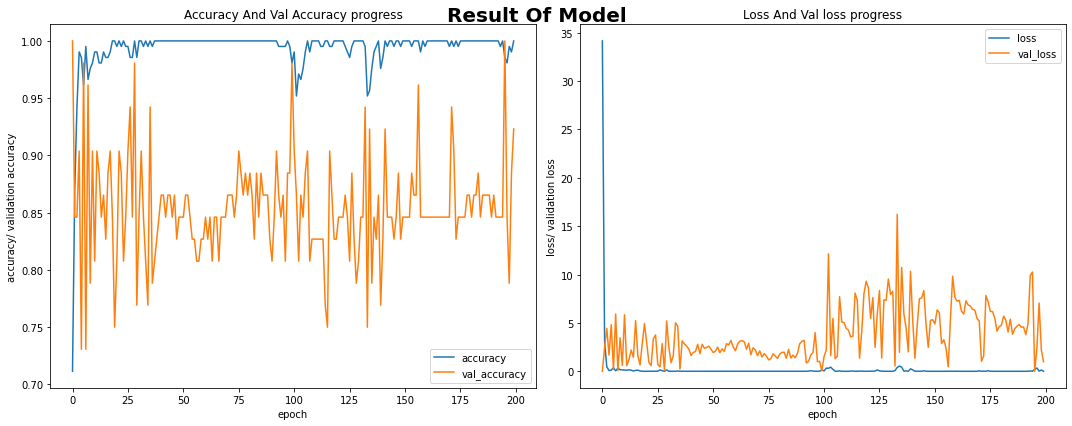

In [29]:
results_plot = plot_results(history_MNV2.history['accuracy'],
                            history_MNV2.history['val_accuracy'], 
                            history_MNV2.history['loss'], 
                            history_MNV2.history['val_loss'])

# enter data to the final results dataframe
results_calc = classification_report(expectedMNV2, predictedMNV2, output_dict=True)

In [30]:
y_test

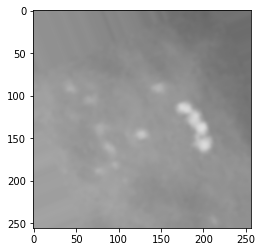

In [31]:
x= y_test.next()
img1 = x[0]
plt.imshow(img1[0])
plt.show()

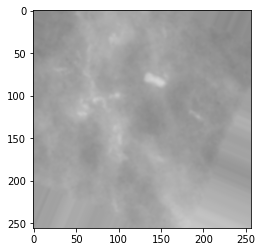

In [32]:
plt.imshow(img1[1])
plt.show()

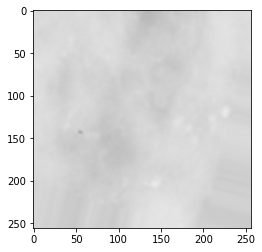

In [33]:
plt.imshow(img1[4])
plt.show()

In [34]:
y_test.labels

[0, 1, 1, 0, 1]

In [35]:
sMNV2 = time.time()
predictionsMNV2 = modelMNV2.predict(y_test)
eMNV2 = time.time()

In [36]:

print("Test time for MNV2: ", eMNV2 - sMNV2,"secs")
mnv2_test_time_5 = (eMNV2 - sMNV2) / 60

Test time for MNV2:  0.5117425918579102 secs


In [37]:
predictedMNV2 = [np.argmax(w) for w in predictionsMNV2]
expectedMNV2 = y_test.labels


In [38]:
print("MNV2 confusion matrix: ")
print(confusion_matrix(expectedMNV2, predictedMNV2))

MNV2 confusion matrix: 
[[2 0]
 [0 3]]


In [39]:
from sklearn import metrics
print(metrics.classification_report(expectedMNV2, predictedMNV2, digits=3))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000         2
           1      1.000     1.000     1.000         3

    accuracy                          1.000         5
   macro avg      1.000     1.000     1.000         5
weighted avg      1.000     1.000     1.000         5



In [40]:
from tensorflow.keras.models import load_model

modelMNV2.save("modelMNV2.h5",modelMNV2)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [41]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
# model=load_model('/content/modelMNV2.h5')
modelMNV2 = tf.keras.models.load_model('modelMNV2.h5')

In [42]:
final_acc = modelMNV2.evaluate(y_val)[1]
print(f"Final accuracy of model is = {final_acc*100}% ")

1/1 [==============================] - 2s 2s/step - loss: 0.4869 - accuracy: 0.9565
Final accuracy of model is = 95.652174949646% 


In [43]:
dict(zip (list(X_train.class_indices.values()), list(X_train.class_indices.keys()) ))

{0: 'B', 1: 'M'}

In [44]:
ref = dict(zip (list(X_train.class_indices.values()), list(X_train.class_indices.keys()) ))

In [45]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [46]:
mammo

,ab_class,bg,p_matrix,severity,subsample_path
mdb001_0_rotated,CIRC,G,"[[0, 0, 0, 0, 1, 1, 3, 4, 4, 4, 5, 5, 5, 6, 5,...",B,../subsamples/mdb001_0_rotated.png
mdb001_0_mirr_lr,CIRC,G,"[[125, 128, 113, 102, 98, 94, 91, 94, 97, 99, ...",B,../subsamples/mdb001_0_mirr_lr.png
mdb001_0_mirr_tp,CIRC,G,"[[0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,...",B,../subsamples/mdb001_0_mirr_tp.png
mdb001_90_rotated,CIRC,G,"[[125, 125, 132, 121, 110, 99, 91, 87, 87, 88,...",B,../subsamples/mdb001_90_rotated.png
mdb001_90_mirr_lr,CIRC,G,"[[59, 59, 61, 64, 65, 64, 67, 70, 73, 75, 77, ...",B,../subsamples/mdb001_90_mirr_lr.png
...,...,...,...,...,...
mdb322_180_mirr_lr,NORM,D,"[[200, 200, 199, 198, 197, 196, 195, 194, 194,...",A,../subsamples/mdb322_180_mirr_lr.png
mdb322_180_mirr_tp,NORM,D,"[[207, 207, 207, 207, 207, 206, 205, 205, 204,...",A,../subsamples/mdb322_180_mirr_tp.png
mdb322_270_rotated,NORM,D,"[[200, 200, 199, 198, 196, 195, 194, 193, 192,...",A,../subsamples/mdb322_270_rotated.png
mdb322_270_mirr_lr,NORM,D,"[[178, 178, 179, 180, 180, 181, 182, 181, 180,...",A,../subsamples/mdb322_270_mirr_lr.png


ValueError: ignored

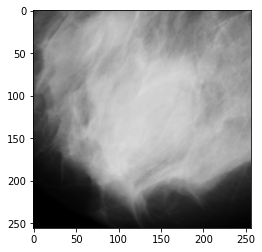

In [47]:
img1 = np.array(image.load_img("../subsamples/mdb001_90_mirr_lr.png",target_size=(256,256)))
plt.imshow(img1)
X1 = img1.reshape(256,256, 3)
pred=np.round(modelMNV2.predict(X1))
pred#0--Benign 1--Malignant